In [ ]:
!pip install pyspark
!pip install networkx

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, count, desc, collect_list
from pyspark.sql.functions import count as spark_count
import networkx as nx
import random

In [ ]:
from pyspark.sql import SparkSession

# Создание SparkSession
spark = SparkSession.builder \
    .appName("Economic Data Analysis") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://localhost:9000") \
    .config("spark.ui.port", "4050") \
    .getOrCreate()

# Установка количества разделов для shuffle операций
spark.conf.set("spark.sql.shuffle.partitions", "50")

In [ ]:
# Чтение данных из HDFS
file_path = "hdfs://localhost:9000/user/hadoop/lab01/input/dataset_group.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

df = df.toDF("date", "basket_number", "product")
print(f"Исходное количество записей: {df.count()}")
print(f"Количество уникальных корзин: {df.select('basket_number').distinct().count()}")
print(f"Количество уникальных товаров: {df.select('product').distinct().count()}")
# Просмотр первых строк данных
df.show(5)

Исходное количество записей: 22342
Количество уникальных корзин: 1139
Количество уникальных товаров: 38
+----------+-------------+-------------+
|      date|basket_number|      product|
+----------+-------------+-------------+
|2000-01-01|            1|         pork|
|2000-01-01|            1|sandwich bags|
|2000-01-01|            1|   lunch meat|
|2000-01-01|            1| all- purpose|
|2000-01-01|            1|        flour|
+----------+-------------+-------------+
only showing top 5 rows



In [ ]:
print("ОБРАБОТКА NULL ЗНАЧЕНИЙ")
# Удаление строк с NULL значениями
df_no_nulls = df.dropna()
print(f"\nПосле удаления NULL значений: {df_no_nulls.count()} записей")

ОБРАБОТКА NULL ЗНАЧЕНИЙ

После удаления NULL значений: 22342 записей


In [ ]:
print("ОБРАБОТКА ДУБЛИКАТОВ")
# Уникальные записи
df_unique = df_no_nulls.dropDuplicates(["date", "basket_number", "product"])
print(f"\nПосле удаления дубликатов: {df_unique.count()} записей")

ОБРАБОТКА ДУБЛИКАТОВ

После удаления дубликатов: 16752 записей


In [ ]:
print("ДОБАВЛЕНИЕ СТОЛБЦА ABANDONED")

# Получение всех уникальные корзины
baskets = df_unique.select("basket_number").distinct().collect()
basket_list = [row.basket_number for row in baskets]

# Случайным образом выбирается 30% корзин как брошенные
random.seed(42)
abandoned_baskets = set(random.sample(basket_list, int(len(basket_list) * 0.3)))

# Создание UDF для определения статуса корзины
from pyspark.sql.types import StringType
from pyspark.sql.functions import udf

def is_abandoned(basket_num):
    return "yes" if basket_num in abandoned_baskets else "no"

abandoned_udf = udf(is_abandoned, StringType())

# Добавление столбца abandoned
df_final = df_unique.withColumn("abandoned", abandoned_udf(col("basket_number")))

print("Данные с добавленным столбцом 'abandoned':")
df_final.show(10)

print(f"\nСтатистика по статусу корзин:")
df_final.groupBy("abandoned").count().show()

ДОБАВЛЕНИЕ СТОЛБЦА ABANDONED
Данные с добавленным столбцом 'abandoned':
+----------+-------------+------------+---------+
|      date|basket_number|     product|abandoned|
+----------+-------------+------------+---------+
|2000-01-01|            1|  vegetables|       no|
|2000-01-01|            2|   hand soap|       no|
|2000-01-03|            7|        soap|       no|
|2000-01-03|            7|all- purpose|       no|
|2000-01-03|            7|        eggs|       no|
|2000-01-11|           23|      bagels|      yes|
|2000-01-11|           23|        milk|      yes|
|2000-01-11|           25|        pork|      yes|
|2000-01-15|           32|     cheeses|       no|
|2000-01-18|           42|   tortillas|      yes|
+----------+-------------+------------+---------+
only showing top 10 rows


Статистика по статусу корзин:
+---------+-----+
|abandoned|count|
+---------+-----+
|      yes| 4948|
|       no|11804|
+---------+-----+



In [ ]:
print("ЗАДАНИЕ 1: Топ-5 товаров в брошенных корзинах")

# Фильтрация только брошенные корзины
abandoned_df = df_final.filter(col("abandoned") == "yes")

# Преобразование в RDD
abandoned_rdd = abandoned_df.rdd.map(lambda row: (row.product, 1))

# Подсчет частоты каждого товара
product_counts_rdd = abandoned_rdd.reduceByKey(lambda a, b: a + b)

# Сортировка по убыванию и выбор топ-5
top_5_abandoned_rdd = product_counts_rdd.sortBy(lambda x: -x[1]).take(5)

print("Топ-5 товаров в брошенных корзинах:")
for i, (product, count) in enumerate(top_5_abandoned_rdd, 1):
    print(f"{i}. {product}: {count} раз")

ЗАДАНИЕ 1: Топ-5 товаров в брошенных корзинах
Топ-5 товаров в брошенных корзинах:
1. vegetables: 255 раз
2. poultry: 157 раз
3. yogurt: 147 раз
4. lunch meat: 144 раз
5. bagels: 142 раз


In [ ]:
print("ЗАДАНИЕ 2: Пары товаров, которые чаще всего покупают вместе")

# Создание временного представления
df_final.createOrReplaceTempView("purchases")

# SQL запрос для нахождения пар товаров в одной корзине
pairs_sql = spark.sql("""
    WITH basket_products AS (
        SELECT basket_number, collect_list(product) as products
        FROM purchases
        GROUP BY basket_number
        HAVING size(products) >= 2
    ),
    numbered_products AS (
        SELECT
            basket_number,
            product,
            ROW_NUMBER() OVER (PARTITION BY basket_number ORDER BY product) as rn
        FROM purchases
    ),
    product_pairs AS (
        SELECT
            a.basket_number,
            a.product as product1,
            b.product as product2
        FROM numbered_products a
        JOIN numbered_products b ON a.basket_number = b.basket_number AND a.rn < b.rn
    )
    SELECT
        product1,
        product2,
        COUNT(*) as co_occurrence
    FROM product_pairs
    GROUP BY product1, product2
    ORDER BY co_occurrence DESC
    LIMIT 10
""")

print("Топ-10 пар товаров, которые чаще всего покупают вместе:")
pairs_sql.show(10)

ЗАДАНИЕ 2: Пары товаров, которые чаще всего покупают вместе
Топ-10 пар товаров, которые чаще всего покупают вместе:
+-----------------+----------+-------------+
|         product1|  product2|co_occurrence|
+-----------------+----------+-------------+
|          poultry|vegetables|          378|
|             eggs|vegetables|          372|
|       vegetables|    yogurt|          363|
|       vegetables|   waffles|          359|
|       lunch meat|vegetables|          355|
|    aluminum foil|vegetables|          354|
|          cereals|vegetables|          354|
|          cheeses|vegetables|          352|
|laundry detergent|vegetables|          352|
|     dinner rolls|vegetables|          351|
+-----------------+----------+-------------+



ЗАДАНИЕ 3: 
Топ-10 самых популярных товаров: vegetables, poultry, ice cream, cereals, lunch meat, waffles, cheeses, soda, eggs, dinner rolls
Найдено 45 уникальных пар товаров
Популярность товаров:
  - vegetables: 842
  - dinner rolls: 443
  - ice cream: 454
  - soda: 445
  - waffles: 449
  - cheeses: 445
  - poultry: 480
  - cereals: 451
  - eggs: 444
  - lunch meat: 450
Граф создан: 10 узлов, 45 ребер


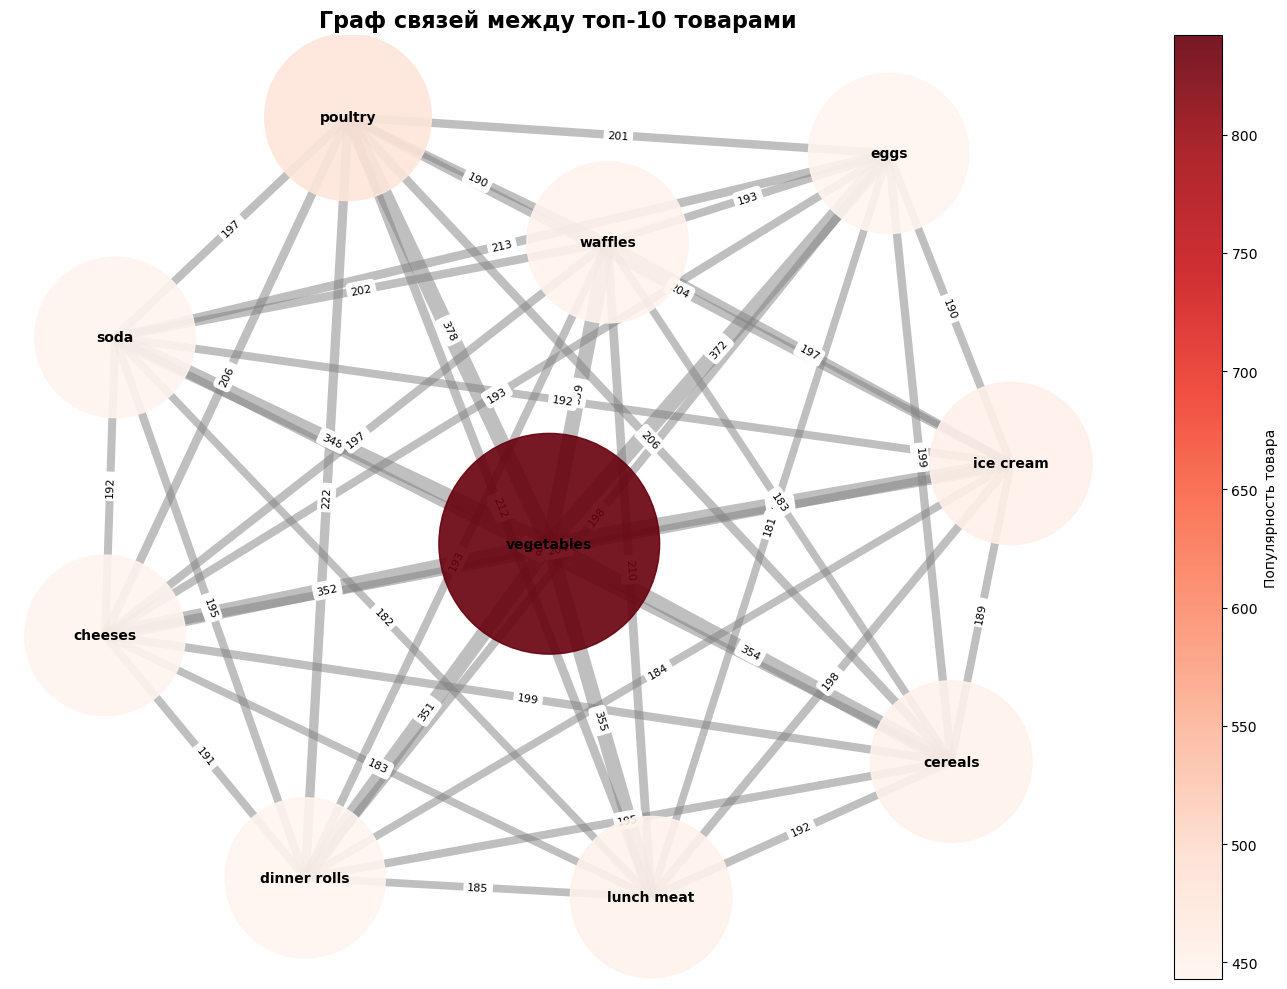

In [ ]:
print("ЗАДАНИЕ 3: ")

top_products = df_final.groupBy("product") \
    .agg(spark_count("*").alias("count")) \
    .orderBy(desc("count")) \
    .limit(10) \
    .select("product") \
    .collect()

top_10_products = [row.product for row in top_products]
print(f"Топ-10 самых популярных товаров: {', '.join(top_10_products)}")

# Все пары для топ-10 товаров
baskets_with_top = df_final.filter(col("product").isin(top_10_products)) \
    .groupBy("basket_number") \
    .agg(collect_list("product").alias("products")) \
    .filter("size(products) >= 2")

# Сбор данных для графа
baskets_data = baskets_with_top.collect()

# Создание словаря для подсчета связей между товарами
edge_weights = {}

for row in baskets_data:
    products = row.products
    for i in range(len(products)):
        for j in range(i+1, len(products)):
            pair = tuple(sorted([products[i], products[j]]))
            edge_weights[pair] = edge_weights.get(pair, 0) + 1

print(f"Найдено {len(edge_weights)} уникальных пар товаров")

# Популярность товаров для размера узлов
product_popularity = df_final.filter(col("product").isin(top_10_products)) \
    .groupBy("product") \
    .agg(spark_count("*").alias("popularity")) \
    .collect()

popularity_dict = {row.product: row.popularity for row in product_popularity}

print("Популярность товаров:")
for product, pop in popularity_dict.items():
    print(f"  - {product}: {pop}")

# Создание графа с помощью NetworkX
G = nx.Graph()

# Добавление узлов с весами
for product in top_10_products:
    G.add_node(product, weight=popularity_dict.get(product, 1))

# Добавление ребер с весами
for (p1, p2), weight in edge_weights.items():
    G.add_edge(p1, p2, weight=weight)

print(f"Граф создан: {G.number_of_nodes()} узлов, {G.number_of_edges()} ребер")

# Визуализация графа
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, k=2, iterations=50)

node_sizes = [G.nodes[node]['weight'] * 30 for node in G.nodes()]
node_colors = [G.nodes[node]['weight'] for node in G.nodes()]

# Отрисовка узлов
nodes = nx.draw_networkx_nodes(G, pos,
                               node_size=node_sizes,
                               node_color=node_colors,
                               cmap=plt.cm.Reds,
                               alpha=0.9)

# Отрисовка ребер
edges = G.edges()
if edges:
    edge_widths = [G[u][v]['weight'] * 0.03 for u, v in edges]
    nx.draw_networkx_edges(G, pos,
                           width=edge_widths,
                           alpha=0.5,
                           edge_color='gray')

# Добавление подписи к узлам
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

# Добавленние подписи к ребрам
if edges:
    edge_labels = {(u, v): f"{G[u][v]['weight']}" for u, v in edges}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

# Добавление цветовой шкалы
plt.colorbar(nodes, label='Популярность товара')

plt.title("Граф связей между топ-10 товарами",
          fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()